In [1]:
versioninfo()

Julia Version 1.9.0
Commit 8e630552924 (2023-05-07 11:25 UTC)
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 16 × AMD Ryzen 7 PRO 4750U with Radeon Graphics
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-14.0.6 (ORCJIT, znver2)
  Threads: 2 on 16 virtual cores
Environment:
  JULIA_PKG_SERVER = https://mirrors.tuna.tsinghua.edu.cn/julia


In [2]:
using Flux, Statistics, ProgressMeter;

In [3]:
# Generate some data for the XOR problem: vectors of length 2, as columns of a matrix:
noisy = rand(Float32, 2, 1000)                                    # 2×1000 Matrix{Float32}
truth = [xor(col[1]>0.5, col[2]>0.5) for col in eachcol(noisy)]   # 1000-element Vector{Bool}

# Define our model, a multi-layer perceptron with one hidden layer of size 3:
model = Chain(
    Dense(2 => 3, tanh),   # activation function inside layer
    BatchNorm(3),
    Dense(3 => 2),
    softmax) |> gpu        # move model to GPU, if available

# The model encapsulates parameters, randomly initialised. Its initial output is:
out1 = model(noisy |> gpu) |> cpu                                 # 2×1000 Matrix{Float32}


┌ Info: The GPU function is being called but the GPU is not accessible. 
└ Defaulting back to the CPU. (No action is required if you want to run on the CPU).


2×1000 Matrix{Float32}:
 0.698994  0.50106  0.310646  0.39511  …  0.492401  0.61895  0.438054
 0.301006  0.49894  0.689354  0.60489     0.507599  0.38105  0.561945

In [8]:
sum(truth)

498

In [4]:
model

Chain(
  Dense(2 => 3, tanh),                  # 9 parameters
  BatchNorm(3),                         # 6 parameters, plus 6
  Dense(3 => 2),                        # 8 parameters
  NNlib.softmax,
)         # Total: 6 trainable arrays, 23 parameters,
          # plus 2 non-trainable, 6 parameters, summarysize 604 bytes.

In [5]:
# To train the model, we use batches of 64 samples, and one-hot encoding:
target = Flux.onehotbatch(truth, [true, false])                   # 2×1000 OneHotMatrix
loader = Flux.DataLoader((noisy, target) |> gpu, batchsize=64, shuffle=true);
# 16-element DataLoader with first element: (2×64 Matrix{Float32}, 2×64 OneHotMatrix)

In [10]:
optim = Flux.setup(Flux.Adam(0.01), model)  # will store optimiser momentum, etc.

# Training loop, using the whole data set 1000 times:
losses = []
@showprogress for epoch in 1:1_000
    for (x, y) in loader
        loss, grads = Flux.withgradient(model) do m
            # Evaluate model and loss inside gradient context:
            y_hat = m(x)
            Flux.crossentropy(y_hat, y)
        end
        Flux.update!(optim, model, grads[1])
        push!(losses, loss)  # logging, outside gradient context
    end
end

display(optim) # parameters, momenta and output have all changed
out2 = model(noisy |> gpu) |> cpu  # first row is prob. of true, second row p(false)
display(out2)
mean((out2[1,:] .> 0.5) .== truth)  # accuracy 94% so far!

Progress: 100%|█████████████████████████████████████████| Time: 0:00:25


(layers = ((weight = Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.00403838 0.220721; 0.0260155 0.0325226; 0.0218586 -0.0085763], Float32[0.000492609 0.533006; 0.0153847 0.00850893; 0.00614888 0.00809249], (2.5e-323, 1.11526e-7))), bias = Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[-0.00757407, 0.0112686, 0.0195884], Float32[0.00538012, 0.0383386, 0.0302606], (2.5e-323, 1.11526e-7))), σ = ()), (λ = (), β = Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.00856396, 0.00623733, -0.00598369], Float32[0.0632163, 0.0334925, 0.031331], (2.5e-323, 1.11526e-7))), γ = Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.0062148, 0.0185563, -0.0257775], Float32[0.0240528, 0.0129186, 0.0136553], (2.5e-323, 1.11526e-7))), μ = (), σ² = (), ϵ = (), momentum = (), affine = (), track_stats = (), active = (), chs = ()), (weight = Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[-0.00392286 -0.0163484 -0.020693; 0.00392285 0.0163484 0.020693], Float32[0.

2×1000 Matrix{Float32}:
 0.99972      9.69545f-6  0.998897    …  3.54098f-5  0.00138633  0.000127233
 0.000280419  0.99999     0.00110324     0.999965    0.998614    0.999873

0.971

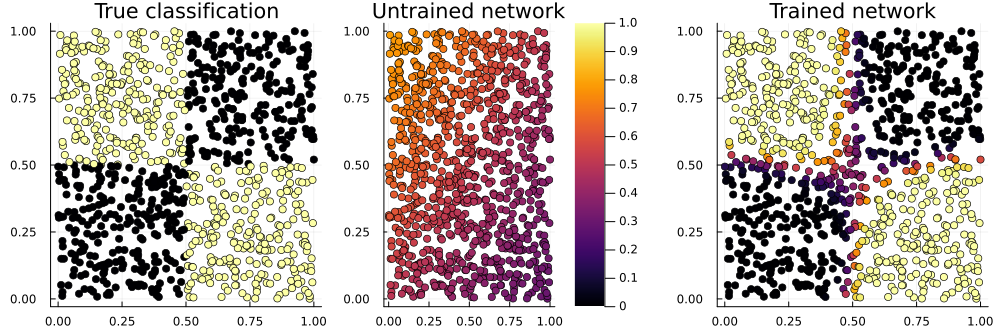

In [11]:
using Plots  # to draw the above figure

p_true = scatter(noisy[1,:], noisy[2,:], zcolor=truth, title="True classification", legend=false)
p_raw =  scatter(noisy[1,:], noisy[2,:], zcolor=out1[1,:], title="Untrained network", label="", clims=(0,1))
p_done = scatter(noisy[1,:], noisy[2,:], zcolor=out2[1,:], title="Trained network", legend=false)

plot(p_true, p_raw, p_done, layout=(1,3), size=(1000,330))

  0.287772 seconds (407.19 k allocations: 25.581 MiB, 9.18% gc time, 98.91% compilation time)


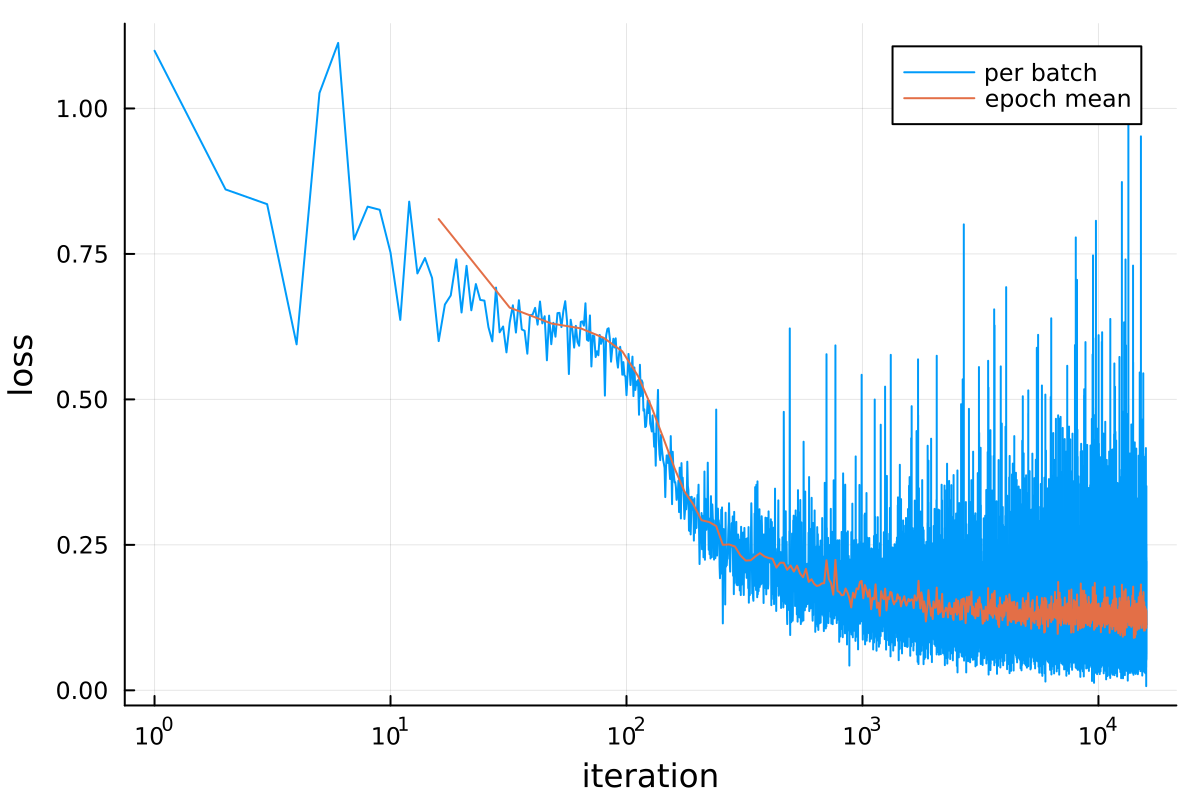

In [12]:
plot(losses; xaxis=(:log10, "iteration"),
    yaxis="loss", label="per batch")
n = length(loader)
@time plot!(n:n:length(losses), mean.(Iterators.partition(losses, n)),
    label="epoch mean", dpi=200)